# Light Curve Modeling for TOI 1148

# Importing Libraries

Before begin the program we must import the libraries that contains the different codes. Here we need three different libraries. First of all obviously a lightkurve, another is numpy that offers comprehensive mathematical functions, random number generators, linear algebra routines, Fourier transforms, and more. And the last is matplotlib that is used for plotting different types of graphs.

In [1]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt

# Path to the files needed to Combine & Detrend

Now, here you can see the code for importing the light curve files. The variable TOI_ID defines the ID of the exoplanet taken into the analysis. We got three files from different sectors.

No. | TESS Sector | Date
--|:---------:|:-----------:
1|Sector 14   | 18/07/2019  
2|Sector 20   | 25/12/2019
3|Sector 21   | 21/01/2020 

The code lk.read will import the file located in the given path and stores it into the variable file_1. Same thing will be for file_2 & file_3. And below this we plotted the scatter plot of the data. As one can observe from the plots, there are much fluctuations other than the transit. These fluctuations occurred due to some systematic errors. So such kind of errors must be removed before further analysis. This part is done in the next section.

In [14]:
TOI_ID = '1148'

file_1 = lk.read('Transit & RV Data/2019-07-18_20-22-14_lc.fits').normalize()
file_2 = lk.read('Transit & RV Data/2019-12-25_00-07-20_lc.fits').normalize()
file_3 = lk.read('Transit & RV Data/2020-01-21_22-27-21_lc.fits').normalize()

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

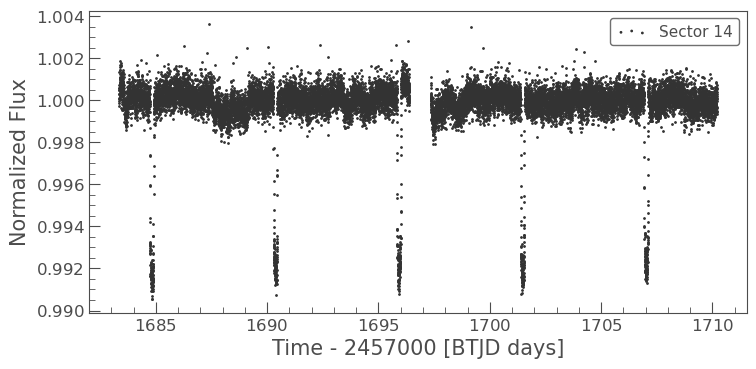

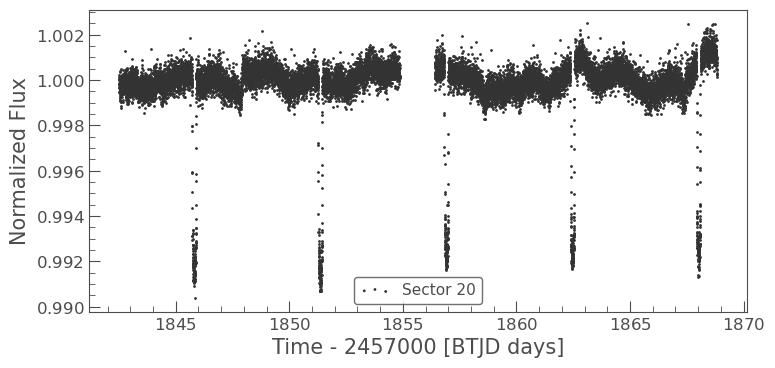

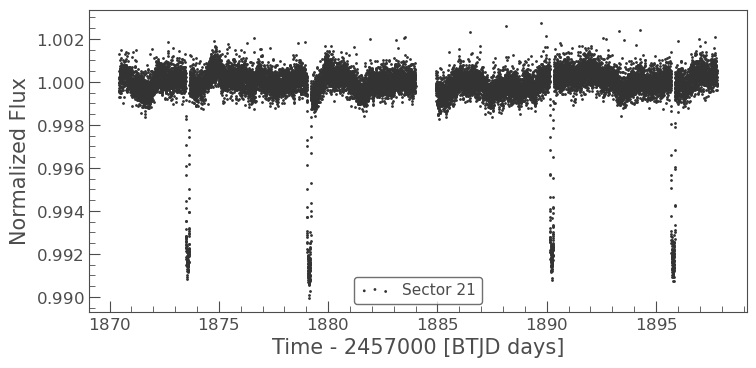

In [20]:
file_1.scatter(label = "Sector 14")
file_2.scatter(label = "Sector 20")
file_3.scatter(label = "Sector 21")

# Combining the Sectors & Plot it

Before de-trending the lightkurve let’s just combined all the sectors to one file so that the resultant values will be much more accurate. The code .append will do this task. Here we created a Combined_TOI file that contains the data of all the three sectors. And this file is plotted below.

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

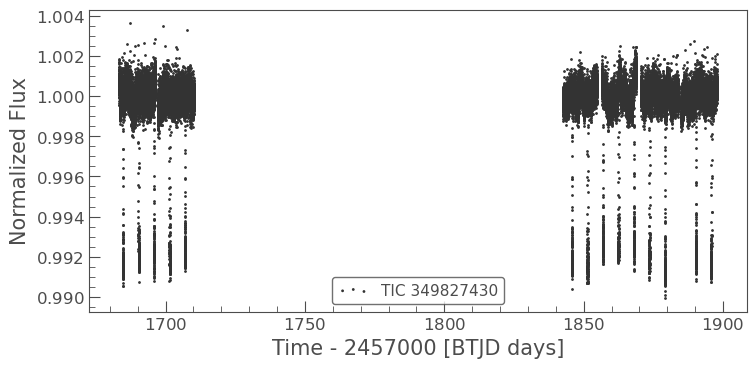

In [21]:
Combined_TOI = file_1.append([file_2, file_3])
Combined_TOI.scatter()

# Periodogram

A periodogram is used to identify the dominant periods (or frequencies) of a time series. This can be a helpful tool for identifying the dominant cyclic behaviour in a series. 

The "Box least Squares" (BLS) periodogram is a statistical method used for detecting transiting exoplanets and eclipsing binaries in time series photometric information. the main interface to this implementation is the BoxLeastSquares class. The 

BLS method reveals transit candidates with the aid of modeling a transit as a periodic upside down top hat with four parameters: period, duration, depth, and a reference time. in this implementation, the reference time is selected to be the mid-transit time of the primary transit within the observational baseline.

 Orbital Period (d) :  5.550000000000004 d 
 Epoch Time (BTJD) :  1684.855706940887 
 Transit Duration (d) :  0.15 d


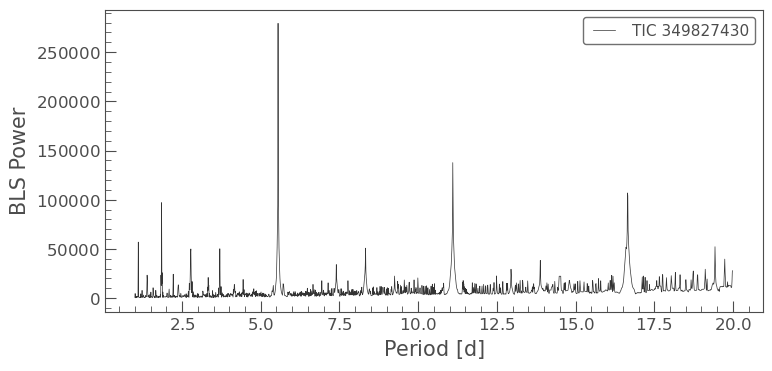

In [7]:
pg = Combined_TOI.to_periodogram(method = 'bls', period = np.arange(1,20,0.01))
pg.plot()

time_period = pg.period_at_max_power
total_transit_time = pg.transit_time_at_max_power
transit_duration = pg.duration_at_max_power

print(" Orbital Period (d) : ", time_period, "\n Epoch Time (BTJD) : ", total_transit_time,\
      "\n Transit Duration (d) : ", transit_duration)

As it can be seen from the above periodogram there are about five significant peaks at different periods. The peak with the highest BLS Power shows the transit events. The exact time period of this peak can be identified by
the code.period_at_max_power, epoch time can be identified by the code .transit_time_at_max_power and finally the transit duration can be measured by code .duration_at_max_power. 

The results are shown above. For the target TOI 1148 orbital period is about 5.55 days, epoch time is 2457000 + 1684.8557 BJD Time, and transit duration is about 0.15 days.

# Masking and Detrending

Now here comes the important part of the analysis "De-trending the light curve". What we did here is that, first we masked all the transit events based on the time period, epoch time and transit duration we got from the previous code. What masking does is it will go through all the data and removes the part that arrives at the given time period. It begins the masking from the epoch time and mask the data that comes into the given time duration. This is how the whole process will be done. 

After the masking process we de-trend the light curve by using the code flatten. One thing must be noted here that before flattening (or de-trending) the light curve, transit events must be masked so that the de-trending must not affect the transit events. 

After the de-trending process we will again plot the periodogram to re check the time period, epoch time and the transit duration much more accurately. The detrended light curve, periodogram and the phase folded light curve is shown below. Here the term phase folded light curve means that, all the transiting events of the data are folded at one point. 

Masking is Done


 Orbital Period (d) :  5.550999999999499 d 
 Epoch Time (BTJD) :  1684.825706940887 
 Transit Duration (d) :  0.15 d


<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

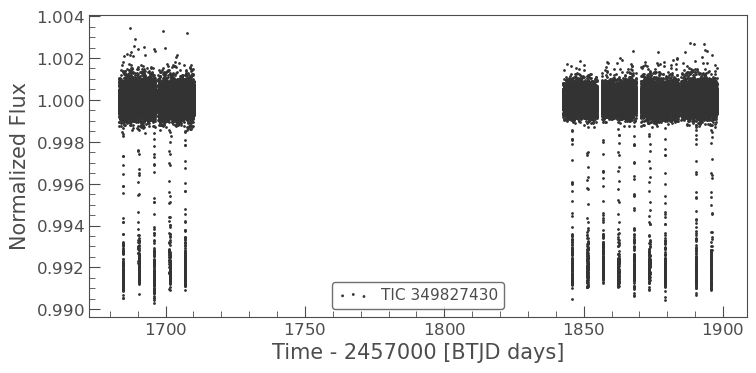

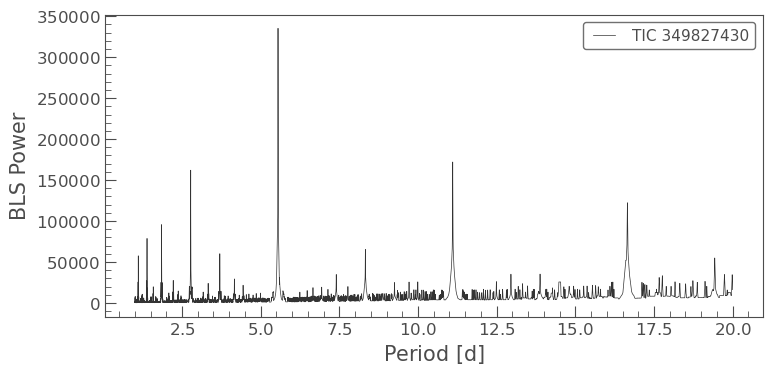

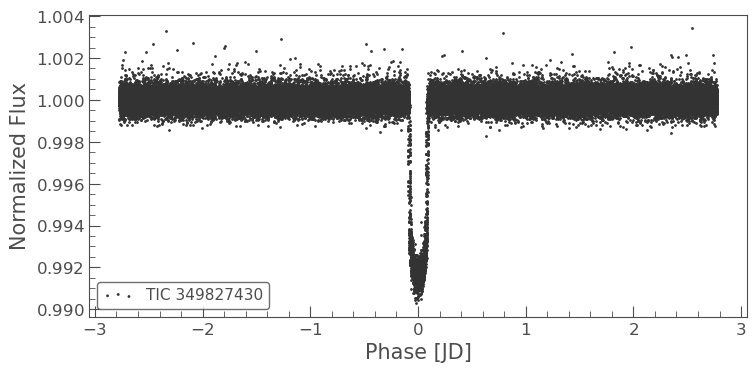

In [13]:
masked_lc = Combined_TOI.create_transit_mask(period = 5.550000000000004 , transit_time = 1684.855706940887, duration = 0.15)
print("Masking is Done")

flat_lc = Combined_TOI.flatten(mask = masked_lc)
flat_lc.scatter()

pg_flatten = flat_lc.to_periodogram(method = 'bls', period = np.arange(1,20,0.001))
pg_flatten.plot()

time_period = pg_flatten.period_at_max_power
transit_time = pg_flatten.transit_time_at_max_power
transit_duration = pg_flatten.duration_at_max_power
print("\n")
print(" Orbital Period (d) : ",time_period,"\n","Epoch Time (BTJD) : ",transit_time,\
      "\n","Transit Duration (d) : ", transit_duration)

folded_lc = flat_lc.fold(period = time_period, epoch_time = transit_time)
folded_lc.scatter()

# Saving the .fits File for further analysis

Now this the thing we wanted for modelling. Here we used this code shown below to append the de-trended and normalized flux along with the errors to the column titled with pdcsap and pdcsap_err. Now in the next section by using the Juliet Python package we will model the whole light curve and determine the planetary parameters.

In [30]:
pdcsap = flat_lc.flux
pdcsap_err = flat_lc.flux_err

processed_lc = flat_lc.to_fits(path = 'Detrended & Combined Lightcurves/Combined_TOI_'+TOI_ID+'.fits', \
                               overwrite = True, pdcsap_flux = pdcsap, pdcsap_flux_err = pdcsap_err)

new = lk.read('Detrended & Combined Lightcurves/Combined_TOI_'+TOI_ID+'.fits')
new

time,flux,flux_err,pdcsap_flux,pdcsap_flux_err,centroid_col,centroid_row,mom_centr1,mom_centr2,quality
,,electron / s,,,,,,,
object,float64,float32,float64,float64,float64,float64,float64,float64,int32
1683.350706940887,1.0000325352116202,0.0003670157748274505,1.0000325352116202,0.0003670157723395195,1612.9917203127602,1675.7811539646364,1612.9917203127602,1675.7811539646364,0
1683.352095821966,0.9998130162387472,0.00036707037361338735,0.9998130162387472,0.00036707036537873806,1612.9903081618781,1675.7821250713223,1612.9903081618781,1675.7821250713223,0
1683.3534847028127,1.000273497779186,0.00036710588028654456,1.000273497779186,0.0003671058703255714,1612.9931837654915,1675.7820084257844,1612.9931837654915,1675.7820084257844,0
1683.3548735838913,0.9993999269973743,0.00036768915015272796,0.9993999269973743,0.00036768915355050937,1612.9948260103,1675.787069717247,1612.9948260103,1675.787069717247,0
1683.3562624649696,1.000106415153518,0.00036734601599164307,1.000106415153518,0.0003673460102048319,1612.9907621182745,1675.7796279238914,1612.9907621182745,1675.7796279238914,0
1683.357651345816,1.0001922104825138,0.00036702831857837737,1.0001922104825138,0.0003670283235995,1612.992073258371,1675.7799684355105,1612.992073258371,1675.7799684355105,0
1683.359040226895,0.9998792900587201,0.00036693847505375743,0.9998792900587201,0.00036693847034728415,1612.995156133719,1675.7863526719054,1612.995156133719,1675.7863526719054,0
1683.3604291079746,1.0009064380096255,0.00036737194750458,1.0009064380096255,0.0003673719465099396,1612.9913937579774,1675.7846428661228,1612.9913937579774,1675.7846428661228,0
